In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import math
import re
import numpy as np
import feather

In [65]:
raw_df = pd.read_csv('data/initial_data.csv')
raw_df.head()

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (52,54) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,interception,penalty,fumble_lost,sack,touchdown,fumble,fumbled_1_team,fumbled_2_team,fumble_recovery_1_team,fumble_recovery_2_team
0,37,2009080950,TEN,BUF,TEN,home,BUF,BUF,30.0,8/9/09,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1,59,2009080950,TEN,BUF,TEN,home,BUF,TEN,74.0,8/9/09,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,83,2009080950,TEN,BUF,TEN,home,BUF,TEN,64.0,8/9/09,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
3,104,2009080950,TEN,BUF,TEN,home,BUF,TEN,67.0,8/9/09,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
4,128,2009080950,TEN,BUF,TEN,home,BUF,TEN,55.0,8/9/09,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [2]:
fixed_df = pd.read_csv('data/fixed_data_v1.csv')

/Users/brendanfreeman/anaconda3/envs/learn-env/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (54,56) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
feather.write_dataframe(fixed_df, 'data/fixed_data_v1.feather')

## Data Preprocessing

In [67]:
raw_df.columns

Index(['play_id', 'game_id', 'home_team', 'away_team', 'posteam',
       'posteam_type', 'defteam', 'side_of_field', 'yardline_100', 'game_date',
       'quarter_seconds_remaining', 'half_seconds_remaining',
       'game_seconds_remaining', 'game_half', 'drive', 'qtr', 'down',
       'goal_to_go', 'time', 'yrdln', 'ydstogo', 'ydsnet', 'play_type',
       'yards_gained', 'home_timeouts_remaining', 'away_timeouts_remaining',
       'posteam_timeouts_remaining', 'defteam_timeouts_remaining',
       'total_home_score', 'total_away_score', 'posteam_score',
       'defteam_score', 'score_differential', 'posteam_score_post',
       'defteam_score_post', 'score_differential_post', 'passer_player_name',
       'rusher_player_name', 'passer_player_id', 'rusher_player_id',
       'season_type', 'desc', 'timeout', 'timeout_team', 'td_team',
       'interception', 'penalty', 'fumble_lost', 'sack', 'touchdown', 'fumble',
       'fumbled_1_team', 'fumbled_2_team', 'fumble_recovery_1_team',
       'fu

### Remove non-plays

In [85]:
fixed_df = raw_df.copy()
fixed_df = fixed_df[~fixed_df['desc'].str.contains("END QUARTER", na=False)]
fixed_df = fixed_df[~fixed_df['desc'].str.contains("END GAME", na=False)]
fixed_df = fixed_df[~fixed_df['desc'].str.contains("Two-Minute Warning", na=False)]
fixed_df = fixed_df[~fixed_df['desc'].str.contains("End of game", na=False)]
fixed_df = fixed_df[~fixed_df['desc'].str.contains("End of quarter", na=False)]
fixed_df = fixed_df[~fixed_df['desc'].str.contains("End of half", na=False)]
fixed_df.reset_index(inplace=True)

### Fill Possession Team  Missing Values

In [86]:
def fill_posteam(row):
    if not isinstance(row['posteam'], str) and math.isnan(row['posteam']):
        prev_idx = row.name - 1
        if row['drive'] == fixed_df['drive'][prev_idx]:
            while not isinstance(fixed_df['posteam'][prev_idx], str):
                prev_idx -= 1
            return fixed_df['posteam'][prev_idx]
        else:
            next_idx = row.name + 1
            while not isinstance(fixed_df['posteam'][next_idx], str):
                next_idx += 1
            return fixed_df['posteam'][next_idx]
    else:
        return row['posteam']

fixed_df['posteam'] = fixed_df.apply(lambda x: fill_posteam(x), axis=1)

### Fill Possession Team Type Missing Values

In [87]:
def fill_posteam_type(row):
    if not isinstance(row['posteam_type'], str) and math.isnan(row['posteam_type']):
        if row['posteam'] is row['home_team']:
            return 'home'
        else:
            return 'away'
    else:
        return row['posteam_type']

fixed_df['posteam_type'] = fixed_df.apply(lambda x: fill_posteam_type(x), axis=1)

### Fill Defense Team Missing Values

In [88]:
def fill_defteam(row):
    if not isinstance(row['defteam'], str) and math.isnan(row['defteam']):
        if row['posteam'] is row['home_team']:
            return row['away_team']
        else:
            return row['home_team']
    else:
        return row['defteam']

fixed_df['defteam'] = fixed_df.apply(lambda x: fill_defteam(x), axis=1)

### Fill Posteam Timeouts Remaining

In [89]:
def fill_posteam_timeouts_remaining(row):
    if math.isnan(row['posteam_timeouts_remaining']):
        if row['posteam'] is row['home_team']:
            return row['home_timeouts_remaining']
        else:
            return row['away_timeouts_remaining']
    else:
        return row['posteam_timeouts_remaining']

fixed_df['posteam_timeouts_remaining'] = fixed_df.apply(lambda x: fill_posteam_timeouts_remaining(x), axis=1)

### Fill Defteam Timeouts Remaining

In [90]:
def fill_defteam_timeouts_remaining(row):
    if math.isnan(row['defteam_timeouts_remaining']):
        if row['defteam'] is row['home_team']:
            return row['home_timeouts_remaining']
        else:
            return row['away_timeouts_remaining']
    else:
        return row['defteam_timeouts_remaining']

fixed_df['defteam_timeouts_remaining'] = fixed_df.apply(lambda x: fill_defteam_timeouts_remaining(x), axis=1)

### Fill Posteam Score

In [91]:
def fill_posteam_score(row):
    if math.isnan(row['posteam_score']):
        if row['posteam'] is row['home_team']:
            return row['total_home_score']
        else:
            return row['total_away_score']
    else:
        return row['posteam_score']

fixed_df['posteam_score'] = fixed_df.apply(lambda x: fill_posteam_score(x), axis=1)

### Fill Defteam Score

In [92]:
def fill_defteam_score(row):
    if math.isnan(row['defteam_score']):
        if row['defteam'] is row['home_team']:
            return row['total_home_score']
        else:
            return row['total_away_score']
    else:
        return row['defteam_score']
    
fixed_df['defteam_score'] = fixed_df.apply(lambda x: fill_defteam_score(x), axis=1)

### Fill Score Differential

In [93]:
def fill_score_differential(row):
    return row['posteam_score'] - row['defteam_score']

fixed_df['score_differential'] = fixed_df.apply(lambda x: fill_score_differential(x), axis=1)

### Fill Down

In [106]:
def fill_down(row):
    if math.isnan(row['down']):
        if row['timeout'] == 1:
            prev_idx = row.name - 1
            while math.isnan(fixed_df['down'][prev_idx]):
                prev_idx -= 1
            return fixed_df['down'][prev_idx]
        else:
            return 'N/A'
    else:
        return row['down']

fixed_df['down'] = fixed_df.apply(lambda x: fill_down(x), axis=1)

### Fill Side of Field Missing Values

In [94]:
def fill_side_of_field(row):
    if not isinstance(row['side_of_field'], str) and math.isnan(row['side_of_field']):
        prev_idx = row.name - 1
        while not isinstance(fixed_df['side_of_field'][prev_idx], str):
            prev_idx -=1
        return fixed_df['side_of_field'][prev_idx]
    else:
        return row['side_of_field']

fixed_df['side_of_field'] = fixed_df.apply(lambda x: fill_side_of_field(x), axis=1)

### Fill Yardline 100 Missing Values

In [95]:
def fill_yardline_100(row):
    if math.isnan(row['yardline_100']):
        prev_idx = row.name - 1
        while math.isnan(fixed_df['yardline_100'][prev_idx]):
            prev_idx -= 1
        return fixed_df['yardline_100'][prev_idx] - fixed_df['yards_gained'][prev_idx]
    else:
        return row['yardline_100']

fixed_df['yardline_100'] = fixed_df.apply(lambda x: fill_yardline_100(x), axis=1)

### Fix Incorrect Plays

In [98]:
def fix_incorrect_plays(row):
    if isinstance(row['desc'], str) and row['desc'].lower().find("scramble") != -1:
        return 'pass'
    elif isinstance(row['desc'], str) and row['desc'].lower().find("pass") != -1:
        return 'pass'
    elif isinstance(row['desc'], str) and row['desc'].lower().find("punt") != -1:
        return 'punt'
    elif isinstance(row['desc'], str) and row['timeout'] == 1 and row['timeout_team'] is row['posteam']:
        return 'timeout'
    elif isinstance(row['desc'], str) and row['desc'].lower().find("kicks") != -1 and row['play_type'] != 'extra_point' and row['play_type'] != "field_goal":
        return 'kickoff'
    elif isinstance(row['desc'], str) and row['desc'].lower().find("sack") != -1:
        return 'pass'
    elif isinstance(row['desc'], str) and row['desc'].lower().find("spike") != -1:
        return 'qb_spike'
    elif isinstance(row['desc'], str) and row['desc'].lower().find("field goal") != -1:
        return 'field_goal'
    elif isinstance(row['desc'], str) and not isinstance(row['play_type'], str) and re.findall("for -*\d+ yard", row['desc']):
        return 'run'
    elif isinstance(row['desc'], str) and row['play_type'] == 'no_play' and re.findall("for -*\d+ yard", row['desc']):
        return 'run'
    elif isinstance(row['desc'], str) and not isinstance(row['play_type'], str) and row['desc'].lower().find("no gain") != -1:
        return 'run'
    elif isinstance(row['desc'], str) and row['play_type'] == 'no_play' and row['desc'].lower().find("no gain") != -1:
        return 'run'
    elif isinstance(row['desc'], str) and not isinstance(row['play_type'], str) and row['desc'].lower().find('run')!= -1:
        return 'run'
    elif isinstance(row['desc'], str) and row['play_type'] == 'no_play' and row['desc'].lower().find('run') != -1:
        return 'run'
    else:
        return row['play_type']

fixed_df['play_type'] = fixed_df.apply(lambda x: fix_incorrect_plays(x), axis=1)
fixed_df.dropna(subset=['play_type'],inplace=True)

### Fill Yards Gained

In [158]:
def fill_yards_gained(row):
    if math.isnan(row['yards_gained']):
        if row['play_type'] == 'pass' or row['play_type'] == 'run' or row['play_type'] == 'qb_kneel':
            prev_idx = row.name - 1
            return row['yardline_100'] - fixed_df['yardline_100'][prev_idx]
    else:
        return row['yards_gained']
    
fixed_df['yards_gained'] = fixed_df.apply(lambda x: fill_yards_gained(x), axis=1)

### Fill Other NaNs

In [145]:
fixed_df.dropna(subset=['time'], inplace=True)
fixed_df['passer_player_name'].fillna('N/A', inplace=True)
fixed_df['passer_player_id'].fillna('N/A', inplace=True)
fixed_df['rusher_player_name'].fillna('N/A', inplace=True)
fixed_df['rusher_player_id'].fillna('N/A', inplace=True)
fixed_df['timeout'].fillna(np.float64(0), inplace=True)
fixed_df['timeout_team'].fillna('N/A', inplace=True)
fixed_df['td_team'].fillna('N/A', inplace=True)
fixed_df['interception'].fillna(np.float64(0), inplace=True)
fixed_df['penalty'].fillna(np.float64(0), inplace=True)
fixed_df['fumble_lost'].fillna(np.float64(0), inplace=True)
fixed_df['sack'].fillna(np.float64(0), inplace=True)
fixed_df['touchdown'].fillna(np.float64(0), inplace=True)
fixed_df['fumble'].fillna(np.float64(0), inplace=True)
fixed_df['fumbled_1_team'].fillna('N/A', inplace=True)
fixed_df['fumbled_2_team'].fillna('N/A', inplace=True)
fixed_df['fumble_recovery_1_team'].fillna('N/A', inplace=True)
fixed_df['fumble_recovery_2_team'].fillna('N/A', inplace=True)
fixed_df['goal_to_go'].fillna(np.float64(0), inplace=True)

### Fill Posession Team Score Post

In [147]:
def fill_posteam_score_post(row):
    if math.isnan(row['posteam_score_post']):
        if row['touchdown'] == 1 and row['interception'] == 0 and row['fumble_lost'] == 0:
            return row['posteam_score'] + 6
        else:
            return row['posteam_score']
    else:
        return row['posteam_score_post']
    
fixed_df['posteam_score_post'] = fixed_df.apply(lambda x: fill_posteam_score_post(x), axis=1)

### Fill Defensive Team Score Post

In [150]:
def fill_defteam_score_post(row):
    if math.isnan(row['defteam_score_post']):
        if row['touchdown'] == 1 and row['interception'] == 1:
            return row['defteam_score'] + 6
        elif row['touchdown'] == 1 and row['fumble_recovery'] == 1:
            return row['defteam_score'] + 6
        else:
            return row['defteam_score']
    else:
        return row['defteam_score_post']
    
fixed_df['defteam_score_post'] = fixed_df.apply(lambda x: fill_defteam_score_post(x), axis=1)

### Fill Score Differential Post

In [152]:
def fill_score_differential_post(row):
    if math.isnan(row['score_differential_post']):
        return row['posteam_score_post'] - row['defteam_score_post']
    else:
        return row['score_differential_post']

fixed_df['score_differential_post'] = fixed_df.apply(lambda x: fill_score_differential_post(x), axis=1)

### Drop Yardline Column and Reset Index

In [160]:
fixed_df.drop(['yrdln'], axis=1, inplace=True)
fixed_df.reset_index(inplace=True)

### Save Cleaned Data

In [162]:
file = open('data/fixed_data_v1.csv', 'w')
fixed_df.to_csv(file)

# Data Visualization

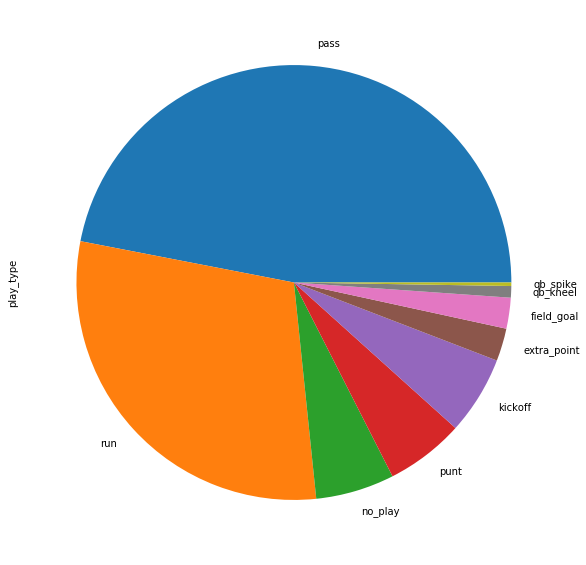

In [163]:
fixed_df['play_type'].value_counts().plot.pie(figsize=(16, 10))

In [168]:
def sum_up_plays(game_id):
    sub_df = fixed_df[fixed_df['game_id'] == game_id]
    for drive in sub_df['drive'].unique():
        if math.isnan(sub_df[sub_df['drive'] == drive]['score_differential'].values[0]):
            if len(sub_df[sub_df['drive'] == drive]['score_differential'].values) == 1:
                continue
            else:
                score = sub_df[sub_df['drive'] == drive]['score_differential'].values[1]
        else:
            score = sub_df[sub_df['drive'] == drive]['score_differential'].values[0]
        pass_plays = 0
        for play in sub_df[sub_df['drive'] == drive]['play_type'].values:
            if play == 'pass':
                pass_plays += 1
        if score in scores_and_plays.keys():
            scores_and_plays[score].append(pass_plays)
        else:
            scores_and_plays[score] = [pass_plays]

In [169]:
scores_and_plays = {}
for game in fixed_df['game_id'].unique():
    sum_up_plays(game)

In [32]:
scores_and_plays

{0.0: [5,
  3,
  2,
  2,
  2,
  3,
  4,
  5,
  3,
  7,
  3,
  7,
  2,
  2,
  6,
  3,
  3,
  5,
  1,
  0,
  0,
  2,
  5,
  3,
  2,
  2,
  4,
  5,
  2,
  2,
  3,
  3,
  3,
  5,
  4,
  0,
  4,
  2,
  1,
  4,
  4,
  3,
  3,
  2,
  3,
  3,
  1,
  3,
  6,
  5,
  3,
  1,
  1,
  4,
  3,
  2,
  5,
  2,
  4,
  4,
  2,
  2,
  1,
  7,
  4,
  2,
  4,
  4,
  4,
  0,
  2,
  2,
  3,
  4,
  3,
  1,
  2,
  2,
  2,
  3,
  4,
  6,
  0,
  2,
  2,
  3,
  1,
  2,
  1,
  3,
  2,
  2,
  1,
  3,
  7,
  10,
  2,
  2,
  2,
  9,
  1,
  2,
  4,
  4,
  6,
  4,
  2,
  3,
  3,
  3,
  5,
  1,
  6,
  7,
  8,
  3,
  1,
  4,
  2,
  2,
  2,
  1,
  1,
  4,
  3,
  4,
  3,
  5,
  5,
  1,
  1,
  3,
  6,
  2,
  3,
  1,
  3,
  3,
  8,
  2,
  5,
  5,
  2,
  4,
  2,
  6,
  3,
  3,
  6,
  3,
  0,
  6,
  5,
  3,
  5,
  4,
  1,
  2,
  7,
  2,
  2,
  1,
  2,
  7,
  6,
  3,
  2,
  1,
  2,
  5,
  4,
  3,
  5,
  2,
  1,
  8,
  7,
  4,
  5,
  2,
  3,
  3,
  4,
  6,
  3,
  2,
  1,
  2,
  3,
  2,
  2,
  3,
  0,
  0,
  5,
  5,
  5,
  3,
  2,

In [20]:
del scores_and_plays[list(scores_and_plays.keys())[0]]

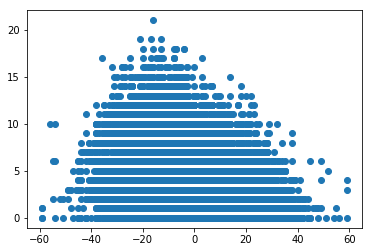

In [170]:
x = []
y = []
for pair in scores_and_plays.items():
    for plays in pair[1]:
        y.append(plays)
        x.append(pair[0])
plot = plt.scatter(x, y)